In [1]:
import pandas as pd
import numpy as np
import sys 
sys.path.insert(0, '/home/yikuan/project/git/CPRD')


from utils.yaml_act import yaml_load
from utils.arg_parse import arg_paser
from CPRD.config.spark import spark_init, read_parquet, read_txt
import pyspark.sql.functions as F
from CPRD.functions import tables, merge, cohort_select,risk_prediction, modalities, MedicalDictionary, risk_prediction, predictor_extractor
from pyspark.sql import Window
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
import warnings

warnings.filterwarnings("ignore")

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [2]:
from lifelines.utils import coalesce, CensoringType, _group_event_table_by_intervals
from lifelines.plotting import PlotEstimateConfig, create_dataframe_slicer

def _plot_estimate(
    cls,
    estimate=None,  # string like "survival_function_", "cumulative_density_", "hazard_", "cumulative_hazard_"
    loc=None,
    iloc=None,
    show_censors=False,
    censor_styles=None,
    ci_legend=False,
    ci_force_lines=False,
    ci_only_lines=False,
    ci_no_lines=False,
    ci_alpha=0.25,
    ci_show=True,
    at_risk_counts=False,
    logx: bool = False,
    ax=None,
    **kwargs
):

    from matplotlib import pyplot as plt

    if ci_force_lines:
        warnings.warn(
            "ci_force_lines is deprecated. Use ci_only_lines instead (no functional difference, only a name change).",
            DeprecationWarning,
        )
        ci_only_lines = ci_force_lines

    plot_estimate_config = PlotEstimateConfig(cls, estimate, loc, iloc, show_censors, censor_styles, logx, ax, **kwargs)

    dataframe_slicer = create_dataframe_slicer(iloc, loc, cls.timeline)

    if show_censors and cls.event_table["censored"].sum() > 0:
        cs = {"marker": "+", "ms": 12, "mew": 1}
        cs.update(plot_estimate_config.censor_styles)
        censored_times = dataframe_slicer(cls.event_table.loc[(cls.event_table["censored"] > 0)]).index.values.astype(float)
        v = plot_estimate_config.predict_at_times(censored_times).values
        plot_estimate_config.ax.plot(censored_times, v, linestyle="None", color=plot_estimate_config.colour, **cs)

    dataframe_slicer(plot_estimate_config.estimate_).rename(columns=lambda _: plot_estimate_config.kwargs.pop("label")).plot(
        logx=plot_estimate_config.logx, **plot_estimate_config.kwargs
    )

    # plot confidence intervals
    if ci_show:
        if ci_only_lines:
            # see https://github.com/CamDavidsonPilon/lifelines/issues/928
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                (
                    dataframe_slicer(plot_estimate_config.confidence_interval_)
                    .rename(columns=lambda s: ("" if ci_legend else "_") + s)
                    .plot(
                        linestyle="-",
                        linewidth=1,
                        color=[plot_estimate_config.colour],
                        drawstyle=plot_estimate_config.kwargs["drawstyle"],
                        alpha=0.6,
                        logx=plot_estimate_config.logx,
                        ax=plot_estimate_config.ax,
                    )
                )
        else:
            x = dataframe_slicer(plot_estimate_config.confidence_interval_).index.values.astype(float)
            lower = dataframe_slicer(plot_estimate_config.confidence_interval_.iloc[:, [0]]).values[:, 0]
            upper = dataframe_slicer(plot_estimate_config.confidence_interval_.iloc[:, [1]]).values[:, 0]

            if plot_estimate_config.kwargs["drawstyle"] == "default":
                step = None
            elif plot_estimate_config.kwargs["drawstyle"].startswith("step"):
                step = plot_estimate_config.kwargs["drawstyle"].replace("steps-", "")

            plot_estimate_config.ax.fill_between(
                x,
                lower,
                upper,
                alpha=ci_alpha,
                color=plot_estimate_config.colour,
                linewidth=0.0 if ci_no_lines else 1.0,
                step=step,
            )

    if at_risk_counts:
        add_at_risk_counts(cls, ax=plot_estimate_config.ax)
        plt.tight_layout()

    return plot_estimate_config.ax

# Inititialise Spark

In [3]:
args = dotdict({'params': '/home/yikuan/project/git/CPRD/config/config.yaml'})
params = yaml_load(args.params)
spark_params = params['pyspark']
spark = spark_init(spark_params)
file = params['file_path']
# data_params = params['params']

# Data Read

In [4]:
data_eval = pd.read_parquet('/home/shared/yikuan/Mo/analysis/CPC/result.parquet')[['patid', 'event', 'time', 'label']]
demographic = pd.read_parquet('/home/shared/yikuan/Mo/demographics.parquet/')

# Data descriptive analysis

In [5]:
demographic = spark.sqlContext.createDataFrame(demographic) 
demographic = demographic.withColumn('HFdate', demographic.baseline + F.expr('INTERVAL 2 YEARS'))
data_eval = spark.sqlContext.createDataFrame(data_eval[['patid', 'label']])

In [6]:
demographic = demographic.join(data_eval, 'patid', 'inner')

# pipeline for treatment extraction
1. last treatment before the HF date + event date
2. first treatment prescription after the HF date + event date

In [7]:
def predictor_check_exist(condition, df, demographics, col, col_baseline='study_entry', before=True):
    # keep all records before the baseline date
    demographics = demographics.select(['patid', col_baseline])
    
    if before:
        df = df.join(demographics, 'patid', 'inner').where(F.col('eventdate') < F.col(col_baseline))
    else:
        df = df.join(demographics, 'patid', 'inner').where(F.col('eventdate') > F.col(col_baseline))
    

    # cast positive patients with exist = 1
    if before:
        w = Window.partitionBy('patid').orderBy(F.col('eventdate').desc())
        df = df.filter(F.col(col).isin(*condition)).withColumn('Rank',  F.dense_rank().over(w))\
            .filter(F.col('Rank') == 1).drop('Rank').select(['patid', 'eventdate'])\
            .dropDuplicates().withColumn('exist', F.lit(1)).withColumnRenamed('eventdate', 'event_recent')
    else:
        w = Window.partitionBy('patid').orderBy(F.col('eventdate'))
        df = df.filter(F.col(col).isin(*condition)).withColumn('Rank',  F.dense_rank().over(w))\
            .filter(F.col('Rank') == 1).drop('Rank').select(['patid', 'eventdate'])\
            .dropDuplicates().withColumn('exist', F.lit(1)).withColumnRenamed('eventdate', 'event_recent')

    demographics = demographics.join(df, 'patid', 'left')

    # separate positive patients and negative patients and set exist = 0 for negative patients
    positive = demographics.filter(F.col('exist').isNotNull())
    negative = demographics.filter(F.col('exist').isNull()).withColumn('exist', F.lit(0))

    # join positive and negative group and select only patid and col columns
    demographics = positive.union(negative).withColumnRenamed('exist', col).select(['patid', col, 'event_recent'])
    return demographics

In [8]:
condition_query = MedicalDictionary.MedicalDictionaryRiskPrediction(file, spark)

In [9]:
medications = read_parquet(spark.sqlContext, '/home/shared/yikuan/HF_Valid/data/medications.parquet').select(['patid', 'prodcode', 'eventdate', 'bnfcode', 'code'])
medications = medications.withColumn('bnf6', F.col('bnfcode').substr(1, 6))

In [10]:
# retrieve procedure
procedure = read_parquet(spark.sqlContext, '/home/shared/yikuan/HF_Valid/data/procedure.parquet')
procedure = procedure.select(['patid', 'eventdate', 'OPCS'])

# Antihypertensive before the HF date
## Antihypertensive (angiotensin-converting-enzyme inhibitors, beta-blockers, calcium channel blockers, diuretics, digoxin)

In [11]:
# digoxin
prod = pd.read_table('./product.txt', encoding='latin-1')
prod = prod[['prodcode', 'productname', 'bnfcode', 'bnfchapter']]
prod['bnf'] = prod.bnfcode.apply(lambda x: x[0:4])
prod = prod[prod['bnf']=='0201']
def process(x):
    x = set(x.split(' '))
    if 'Digoxin' in x:
        return 1
    else:
        return 0

prod['name'] = prod.productname.apply(lambda x: process(x))
prod = prod[prod['name']==1]

code_list = [str(each) for each in prod.prodcode.values]

name = 'digoxin'

code = predictor_check_exist(code_list, medications, demographic, col='prodcode', col_baseline='HFdate', before=True) \
            .withColumnRenamed('prodcode', '{}_before'.format(name))\
            .withColumnRenamed('event_recent', 'event_recent_before')
demographic = demographic.join(code, 'patid', 'left')

code = predictor_check_exist(code_list, medications, demographic, col='prodcode', col_baseline='HFdate', before=False) \
            .withColumnRenamed('prodcode', '{}_after'.format(name))\
            .withColumnRenamed('event_recent', 'event_recent_after')
demographic = demographic.join(code, 'patid', 'left')
demographic.write.parquet('/home/shared/yikuan/Mo/analysis/{}.parquet'.format(name))

# MRAs

In [17]:
# MRAs
prod = pd.read_table('./product.txt', encoding='latin-1')
prod = prod[['prodcode', 'productname', 'bnfcode', 'bnfchapter']]
prod['bnf'] = prod.bnfcode.apply(lambda x: x[0:6])
prod = prod[prod['bnf']=='020203']

code_list = [str(each) for each in prod.prodcode.values]

name = 'MRAs'

code = predictor_check_exist(code_list, medications, demographic, col='prodcode', col_baseline='HFdate', before=True) \
            .withColumnRenamed('prodcode', '{}_before'.format(name))\
            .withColumnRenamed('event_recent', 'event_recent_before')
demographic = demographic.join(code, 'patid', 'left')

code = predictor_check_exist(code_list, medications, demographic, col='prodcode', col_baseline='HFdate', before=False) \
            .withColumnRenamed('prodcode', '{}_after'.format(name))\
            .withColumnRenamed('event_recent', 'event_recent_after')
demographic = demographic.join(code, 'patid', 'left')
demographic.write.parquet('/home/shared/yikuan/Mo/analysis/{}.parquet'.format(name))

# beta-blocker

In [11]:
# Beta-blocker
antihyp = condition_query.queryMedication(['antihypertensives'])
antihyp = antihyp.get('antihypertensives').get('prod')

code_list = antihyp

name = 'beta_blocker'

code = predictor_check_exist(code_list, medications, demographic, col='prodcode', col_baseline='HFdate', before=True) \
            .withColumnRenamed('prodcode', '{}_before'.format(name))\
            .withColumnRenamed('event_recent', 'event_recent_before')
demographic = demographic.join(code, 'patid', 'left')


prod = pd.read_table('./prod_antihypertensives.v1.txt', encoding='latin-1')
# prod = prod[['prodcode', 'productname', 'bnfcode', 'bnfchapter']]
prod['bnf'] = prod.bnf_code.apply(lambda x: x[0:4])
prod = prod[prod['bnf']=='0204']

code_list = [str(each) for each in prod.cprd_prodcode.values]


code = predictor_check_exist(code_list, medications, demographic, col='prodcode', col_baseline='HFdate', before=False) \
            .withColumnRenamed('prodcode', '{}_after'.format(name))\
            .withColumnRenamed('event_recent', 'event_recent_after')
demographic = demographic.join(code, 'patid', 'left')
demographic.write.parquet('/home/shared/yikuan/Mo/analysis/{}.parquet'.format(name))

# Analysis

In [12]:
def processing(demographic_window, name, label):
    def check_window(hf_date, event_date, window):
        if not event_date:
            return 0


        if abs((hf_date - event_date).days) <= window:
            return 1
        else:
            return 0

    demographic_window['{}_before'.format(name)] = demographic_window[['HFdate', 'event_recent_before']].apply(lambda x: check_window(x[0],x[1],730), axis=1)
    demographic_window['{}_after'.format(name)] = demographic_window[['HFdate', 'event_recent_after']].apply(lambda x: check_window(x[0],x[1],365), axis=1)

    data = demographic_window.groupby(label).agg(
        No_total_patient= ('patid', lambda x: x.count()),
        No_treated_before = ('{}_before'.format(name), sum)
    )
    data['pct_treated_before'] = data.apply(lambda x: x[1]/x[0], axis=1)

    no_ant = demographic_window[demographic_window['{}_before'.format(name)]==0]
    no_ant = no_ant.groupby(label).agg(
        No_treated_after = ('{}_after'.format(name), sum)
    )
    data = data.merge(no_ant, on=label, how='left')
    data['pct_treated_after'] = data.apply(lambda x: x[3]/(x[0]-x[1]), axis=1)
    data = data.rename(columns={"No_treated_after": "No_treated_after(not before)"})
    mortality = pd.read_parquet('/home/shared/yikuan/Mo/mortality_imp.parquet')[['patid', 'event', 'time']]
    mortality['time'] = mortality.time.apply(lambda x: x-24)

    demographic_window = demographic_window[demographic_window['{}_before'.format(name)]==0].merge(mortality, on='patid', how='left')
    return demographic_window, data

In [13]:
def plot(demographic_window, name, label, row, col, figsize=(20, 10),groups=None):

    fig = plt.figure(figsize=figsize, dpi=300)
    cnt = 0
    for idx, group in demographic_window.groupby(label):
        if groups is None or group[label].values[0] in groups:
            cnt += 1
            ax = fig.add_subplot(row,col, cnt)

            treated = group[group['{}_after'.format(name)]==1]

            kmf = KaplanMeierFitter()
            kmf.fit(treated.time.values, event_observed=treated.event.values)

            ax = _plot_estimate(kmf, estimate="survival_function_", ax=ax, label='Treated group')


            control = group[group['{}_after'.format(name)]==0]

            kmf = KaplanMeierFitter()
            kmf.fit(control.time.values, event_observed=control.event.values)

            ax = _plot_estimate(kmf, estimate="survival_function_", ax=ax, label='Control group')
            ax.set_xlabel('time (month)')
            ax.set_title('group {}'.format(str(control[label].values[0])))
            
            if cnt != [row * col, row*col-1]:
                ax.set_xlabel('')
    
    return fig

In [14]:
from lifelines.utils import coalesce, CensoringType, _group_event_table_by_intervals
from lifelines.plotting import PlotEstimateConfig, create_dataframe_slicer

def _plot_estimate(
    cls,
    estimate=None,  # string like "survival_function_", "cumulative_density_", "hazard_", "cumulative_hazard_"
    loc=None,
    iloc=None,
    show_censors=False,
    censor_styles=None,
    ci_legend=False,
    ci_force_lines=False,
    ci_only_lines=False,
    ci_no_lines=False,
    ci_alpha=0.25,
    ci_show=True,
    at_risk_counts=False,
    logx: bool = False,
    ax=None,
    **kwargs
):

    from matplotlib import pyplot as plt

    if ci_force_lines:
        warnings.warn(
            "ci_force_lines is deprecated. Use ci_only_lines instead (no functional difference, only a name change).",
            DeprecationWarning,
        )
        ci_only_lines = ci_force_lines

    plot_estimate_config = PlotEstimateConfig(cls, estimate, loc, iloc, show_censors, censor_styles, logx, ax, **kwargs)

    dataframe_slicer = create_dataframe_slicer(iloc, loc, cls.timeline)

    if show_censors and cls.event_table["censored"].sum() > 0:
        cs = {"marker": "+", "ms": 12, "mew": 1}
        cs.update(plot_estimate_config.censor_styles)
        censored_times = dataframe_slicer(cls.event_table.loc[(cls.event_table["censored"] > 0)]).index.values.astype(float)
        v = plot_estimate_config.predict_at_times(censored_times).values
        plot_estimate_config.ax.plot(censored_times, v, linestyle="None", color=plot_estimate_config.colour, **cs)

    dataframe_slicer(plot_estimate_config.estimate_).rename(columns=lambda _: plot_estimate_config.kwargs.pop("label")).plot(
        logx=plot_estimate_config.logx, **plot_estimate_config.kwargs
    )

    # plot confidence intervals
    if ci_show:
        if ci_only_lines:
            # see https://github.com/CamDavidsonPilon/lifelines/issues/928
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                (
                    dataframe_slicer(plot_estimate_config.confidence_interval_)
                    .rename(columns=lambda s: ("" if ci_legend else "_") + s)
                    .plot(
                        linestyle="-",
                        linewidth=1,
                        color=[plot_estimate_config.colour],
                        drawstyle=plot_estimate_config.kwargs["drawstyle"],
                        alpha=0.6,
                        logx=plot_estimate_config.logx,
                        ax=plot_estimate_config.ax,
                    )
                )
        else:
            x = dataframe_slicer(plot_estimate_config.confidence_interval_).index.values.astype(float)
            lower = dataframe_slicer(plot_estimate_config.confidence_interval_.iloc[:, [0]]).values[:, 0]
            upper = dataframe_slicer(plot_estimate_config.confidence_interval_.iloc[:, [1]]).values[:, 0]

            if plot_estimate_config.kwargs["drawstyle"] == "default":
                step = None
            elif plot_estimate_config.kwargs["drawstyle"].startswith("step"):
                step = plot_estimate_config.kwargs["drawstyle"].replace("steps-", "")

            plot_estimate_config.ax.fill_between(
                x,
                lower,
                upper,
                alpha=ci_alpha,
                color=plot_estimate_config.colour,
                linewidth=0.0 if ci_no_lines else 1.0,
                step=step,
            )

    if at_risk_counts:
        add_at_risk_counts(cls, ax=plot_estimate_config.ax)
        plt.tight_layout()

    return plot_estimate_config.ax

# MRAs

In [15]:
data = pd.read_parquet('/home/shared/yikuan/Mo/analysis/MRAs.parquet')
kmeans = pd.read_parquet('/home/shared/yikuan/Mo/analysis/kmeans/label.paruqet')[['patid', 'label']]
kmeans = kmeans.rename(columns={'label': 'kmeans_label'})
tfidf = pd.read_parquet('/home/shared/yikuan/Mo/analysis/tfidf/label.paruqet')[['patid', 'label']]
tfidf = tfidf.rename(columns={'label': 'tfidf_label'})

In [16]:
data = data.merge(kmeans, on='patid', how='inner').merge(tfidf, on='patid', how='inner')

In [17]:
demo, desc = processing(data, 'MRAs', 'tfidf_label')

In [18]:
desc

,No_total_patient,No_treated_before,pct_treated_before,No_treated_after(not before),pct_treated_after
tfidf_label,,,,,
0,2875,477,0.165913,503,0.209758
1,20165,255,0.012646,865,0.043446
2,7703,804,0.104375,1440,0.208726
3,9310,610,0.065521,1331,0.152989
4,3289,325,0.098814,679,0.229082
5,2940,275,0.093537,530,0.198874
6,4656,364,0.078179,777,0.181034
7,1914,163,0.085162,293,0.167333


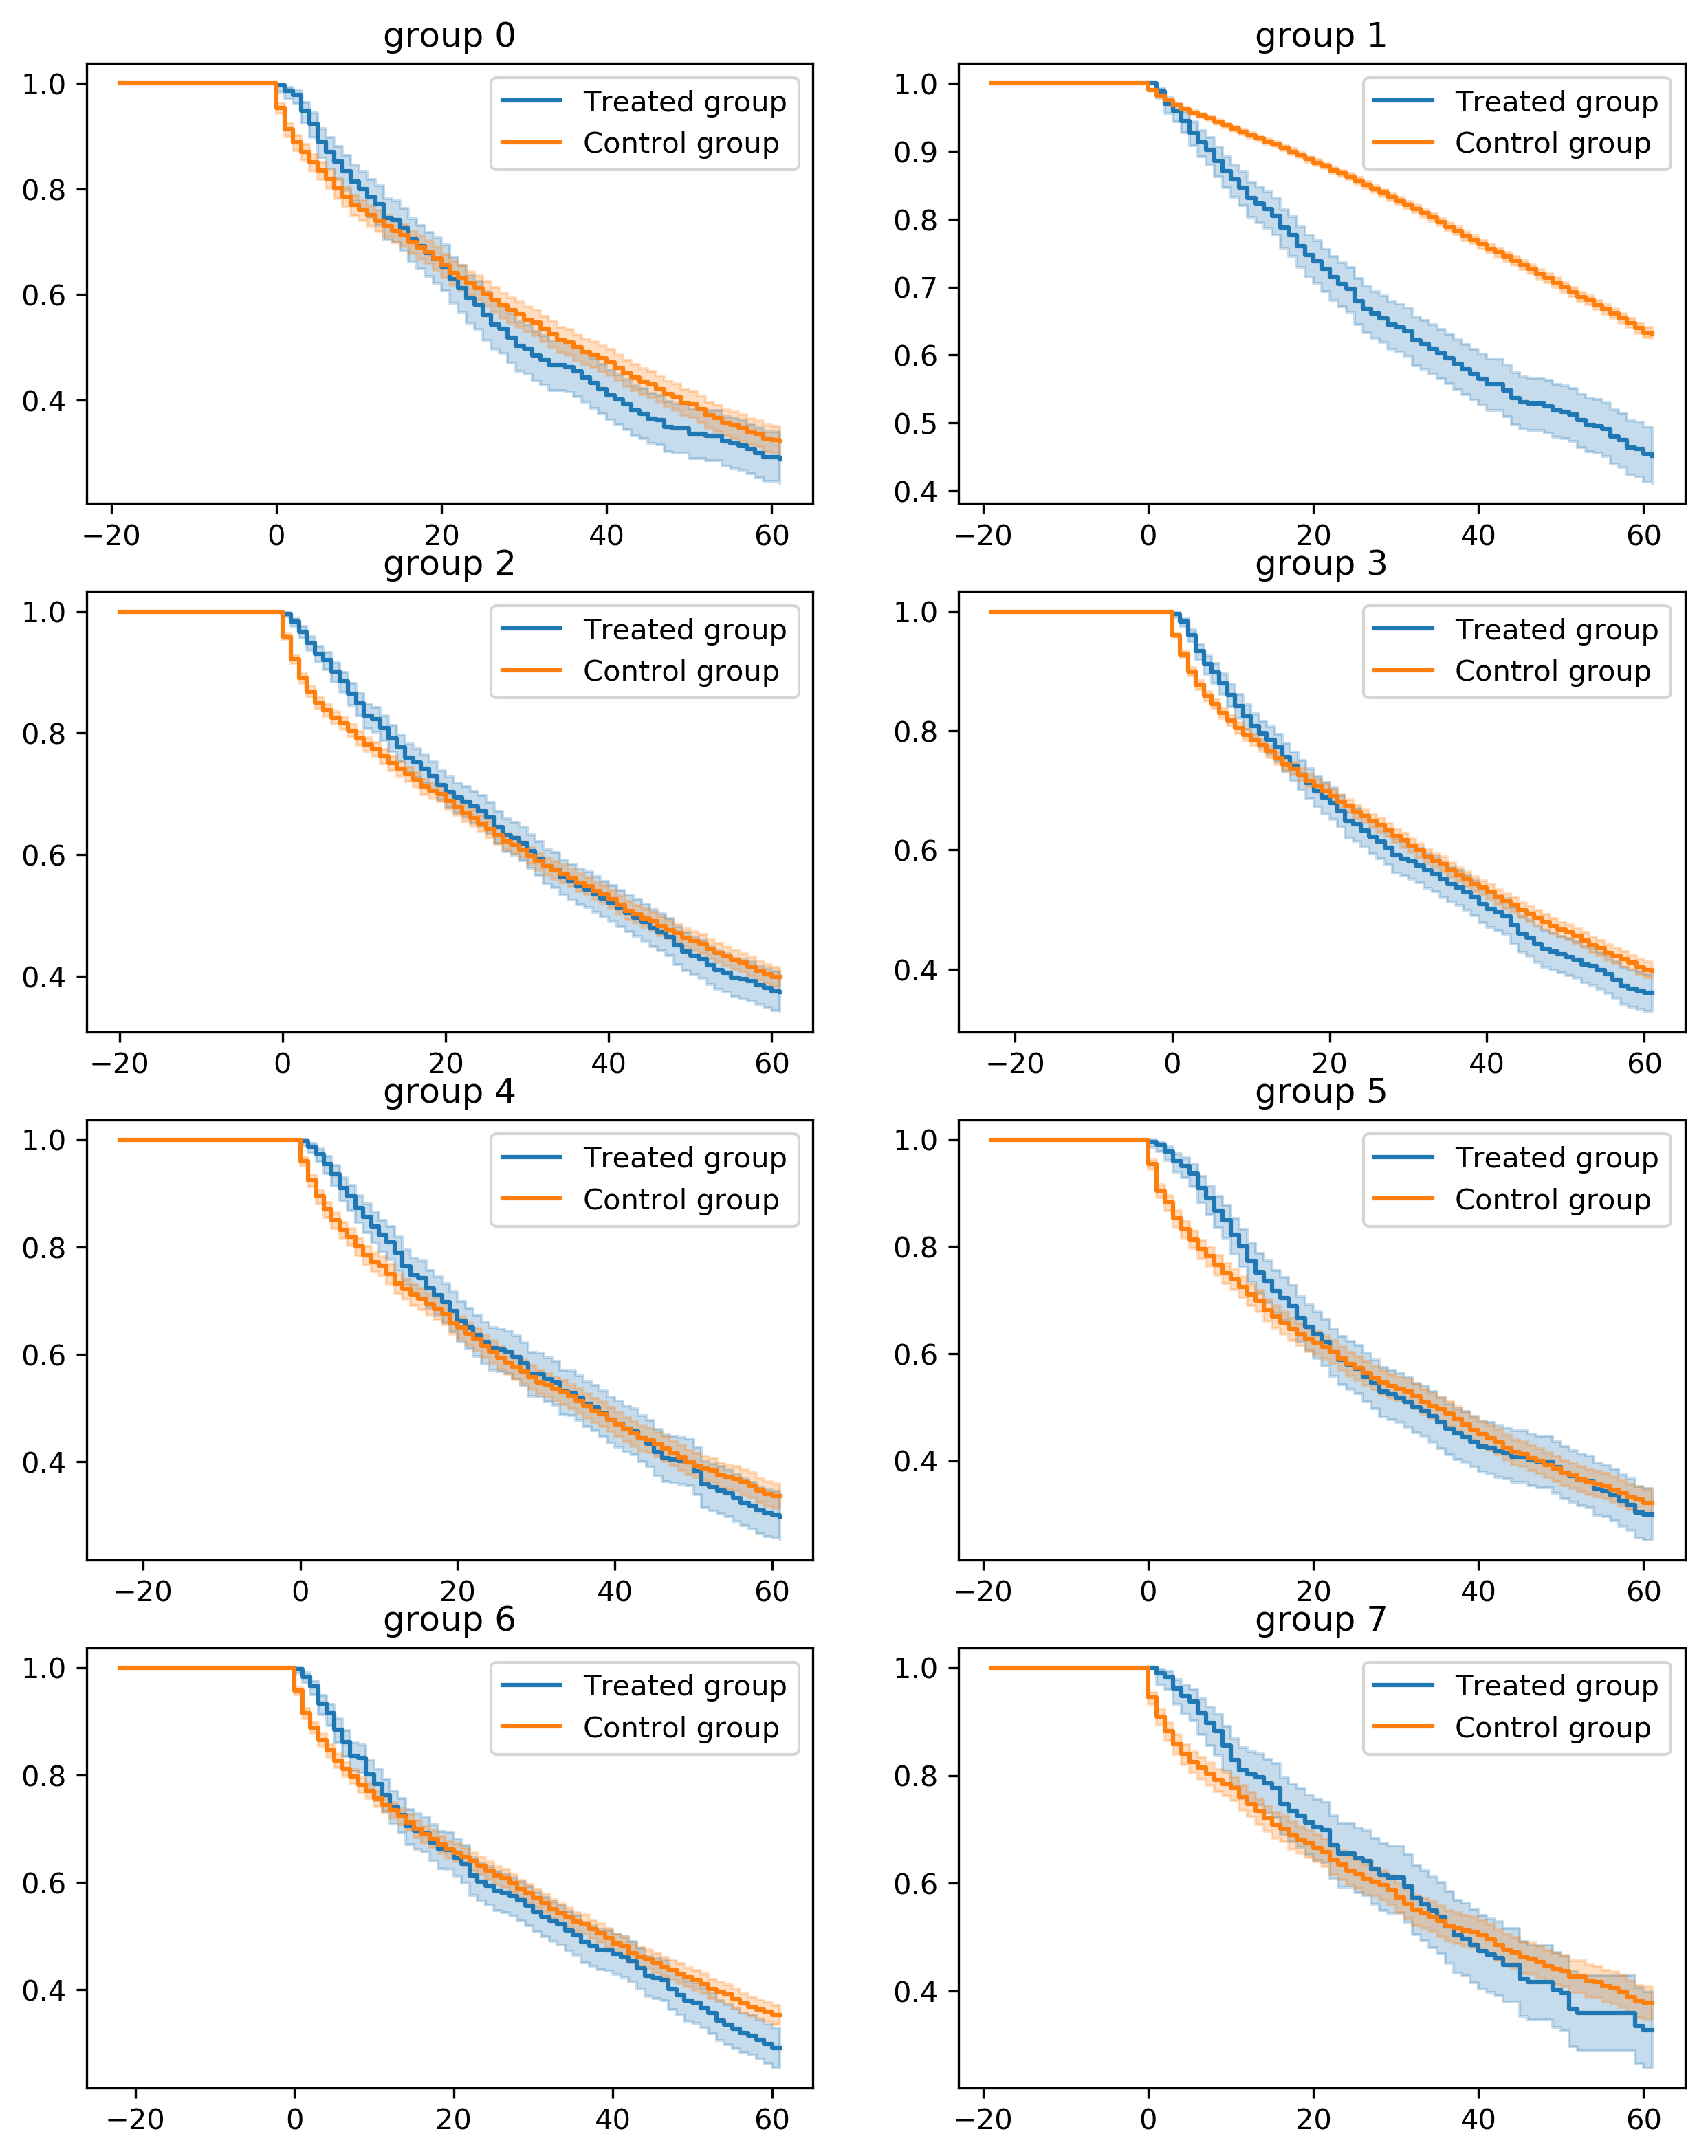

In [76]:
fig = plot(demo, 'MRAs', 'tfidf_label', 4, 2,groups=None, figsize=(10,13))
plt.show()

# Beta-blockers

In [82]:
data = pd.read_parquet('/home/shared/yikuan/Mo/analysis/beta_blocker.parquet')
kmeans = pd.read_parquet('/home/shared/yikuan/Mo/analysis/kmeans/label.paruqet')[['patid', 'label']]
kmeans = kmeans.rename(columns={'label': 'kmeans_label'})
tfidf = pd.read_parquet('/home/shared/yikuan/Mo/analysis/tfidf/label.paruqet')[['patid', 'label']]
tfidf = tfidf.rename(columns={'label': 'tfidf_label'})

In [83]:
data = data.merge(kmeans, on='patid', how='inner').merge(tfidf, on='patid', how='inner')

In [84]:
demo, desc = processing(data, 'beta_blocker', 'kmeans_label')

In [85]:
desc

,No_total_patient,No_treated_before,pct_treated_before,No_treated_after(not before),pct_treated_after
kmeans_label,,,,,
0,33137,18534,0.559314,815,0.055810
1,9,6,0.666667,0,0.000000
2,11,8,0.727273,2,0.666667
3,19695,9195,0.466870,1113,0.106000


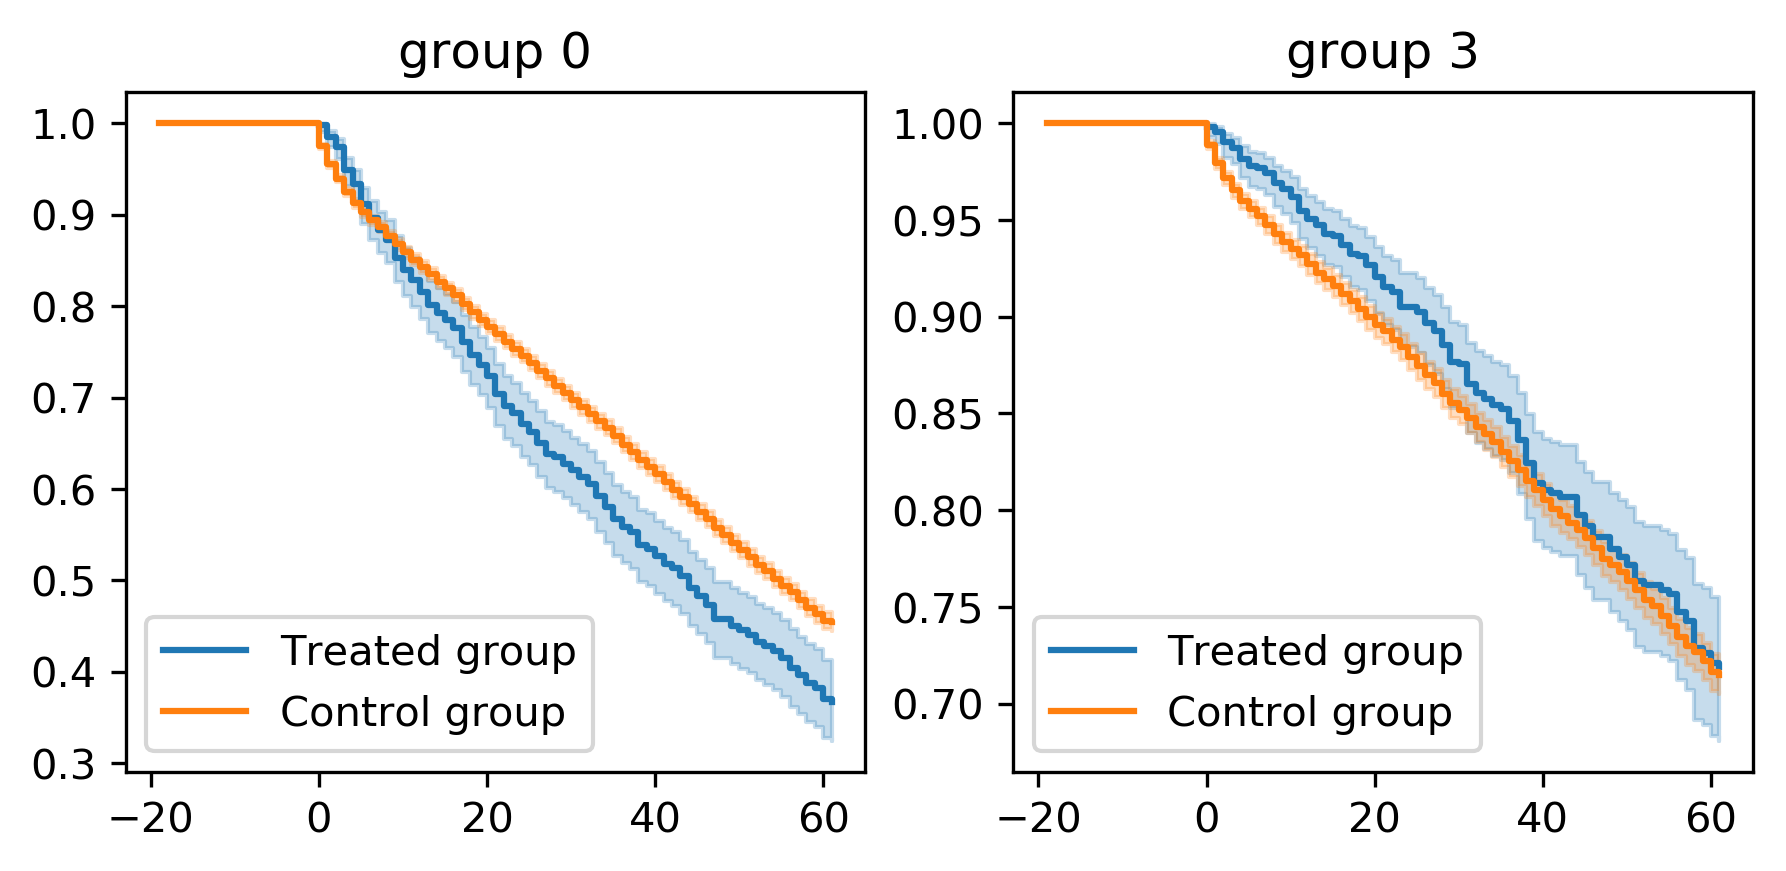

In [93]:
fig = plot(demo, 'beta_blocker', 'kmeans_label', 1, 2,groups=[0, 3], figsize=(7,3))
plt.show()

# Digoxin

In [110]:
data = pd.read_parquet('/home/shared/yikuan/Mo/analysis/digoxin.parquet')
kmeans = pd.read_parquet('/home/shared/yikuan/Mo/analysis/kmeans/label.paruqet')[['patid', 'label']]
kmeans = kmeans.rename(columns={'label': 'kmeans_label'})
tfidf = pd.read_parquet('/home/shared/yikuan/Mo/analysis/tfidf/label.paruqet')[['patid', 'label']]
tfidf = tfidf.rename(columns={'label': 'tfidf_label'})

In [111]:
data = data.merge(kmeans, on='patid', how='inner').merge(tfidf, on='patid', how='inner')

In [112]:
demo, desc = processing(data, 'digoxin', 'tfidf_label')

In [113]:
desc

,No_total_patient,No_treated_before,pct_treated_before,No_treated_after(not before),pct_treated_after
tfidf_label,,,,,
0,2875,1866,0.649043,142,0.140733
1,20165,526,0.026085,759,0.038648
2,7703,787,0.102168,889,0.128543
3,9310,1011,0.108593,1046,0.126039
4,3289,346,0.105199,267,0.090724
5,2940,371,0.126190,349,0.135851
6,4656,526,0.112973,508,0.123002
7,1914,259,0.135319,163,0.098489


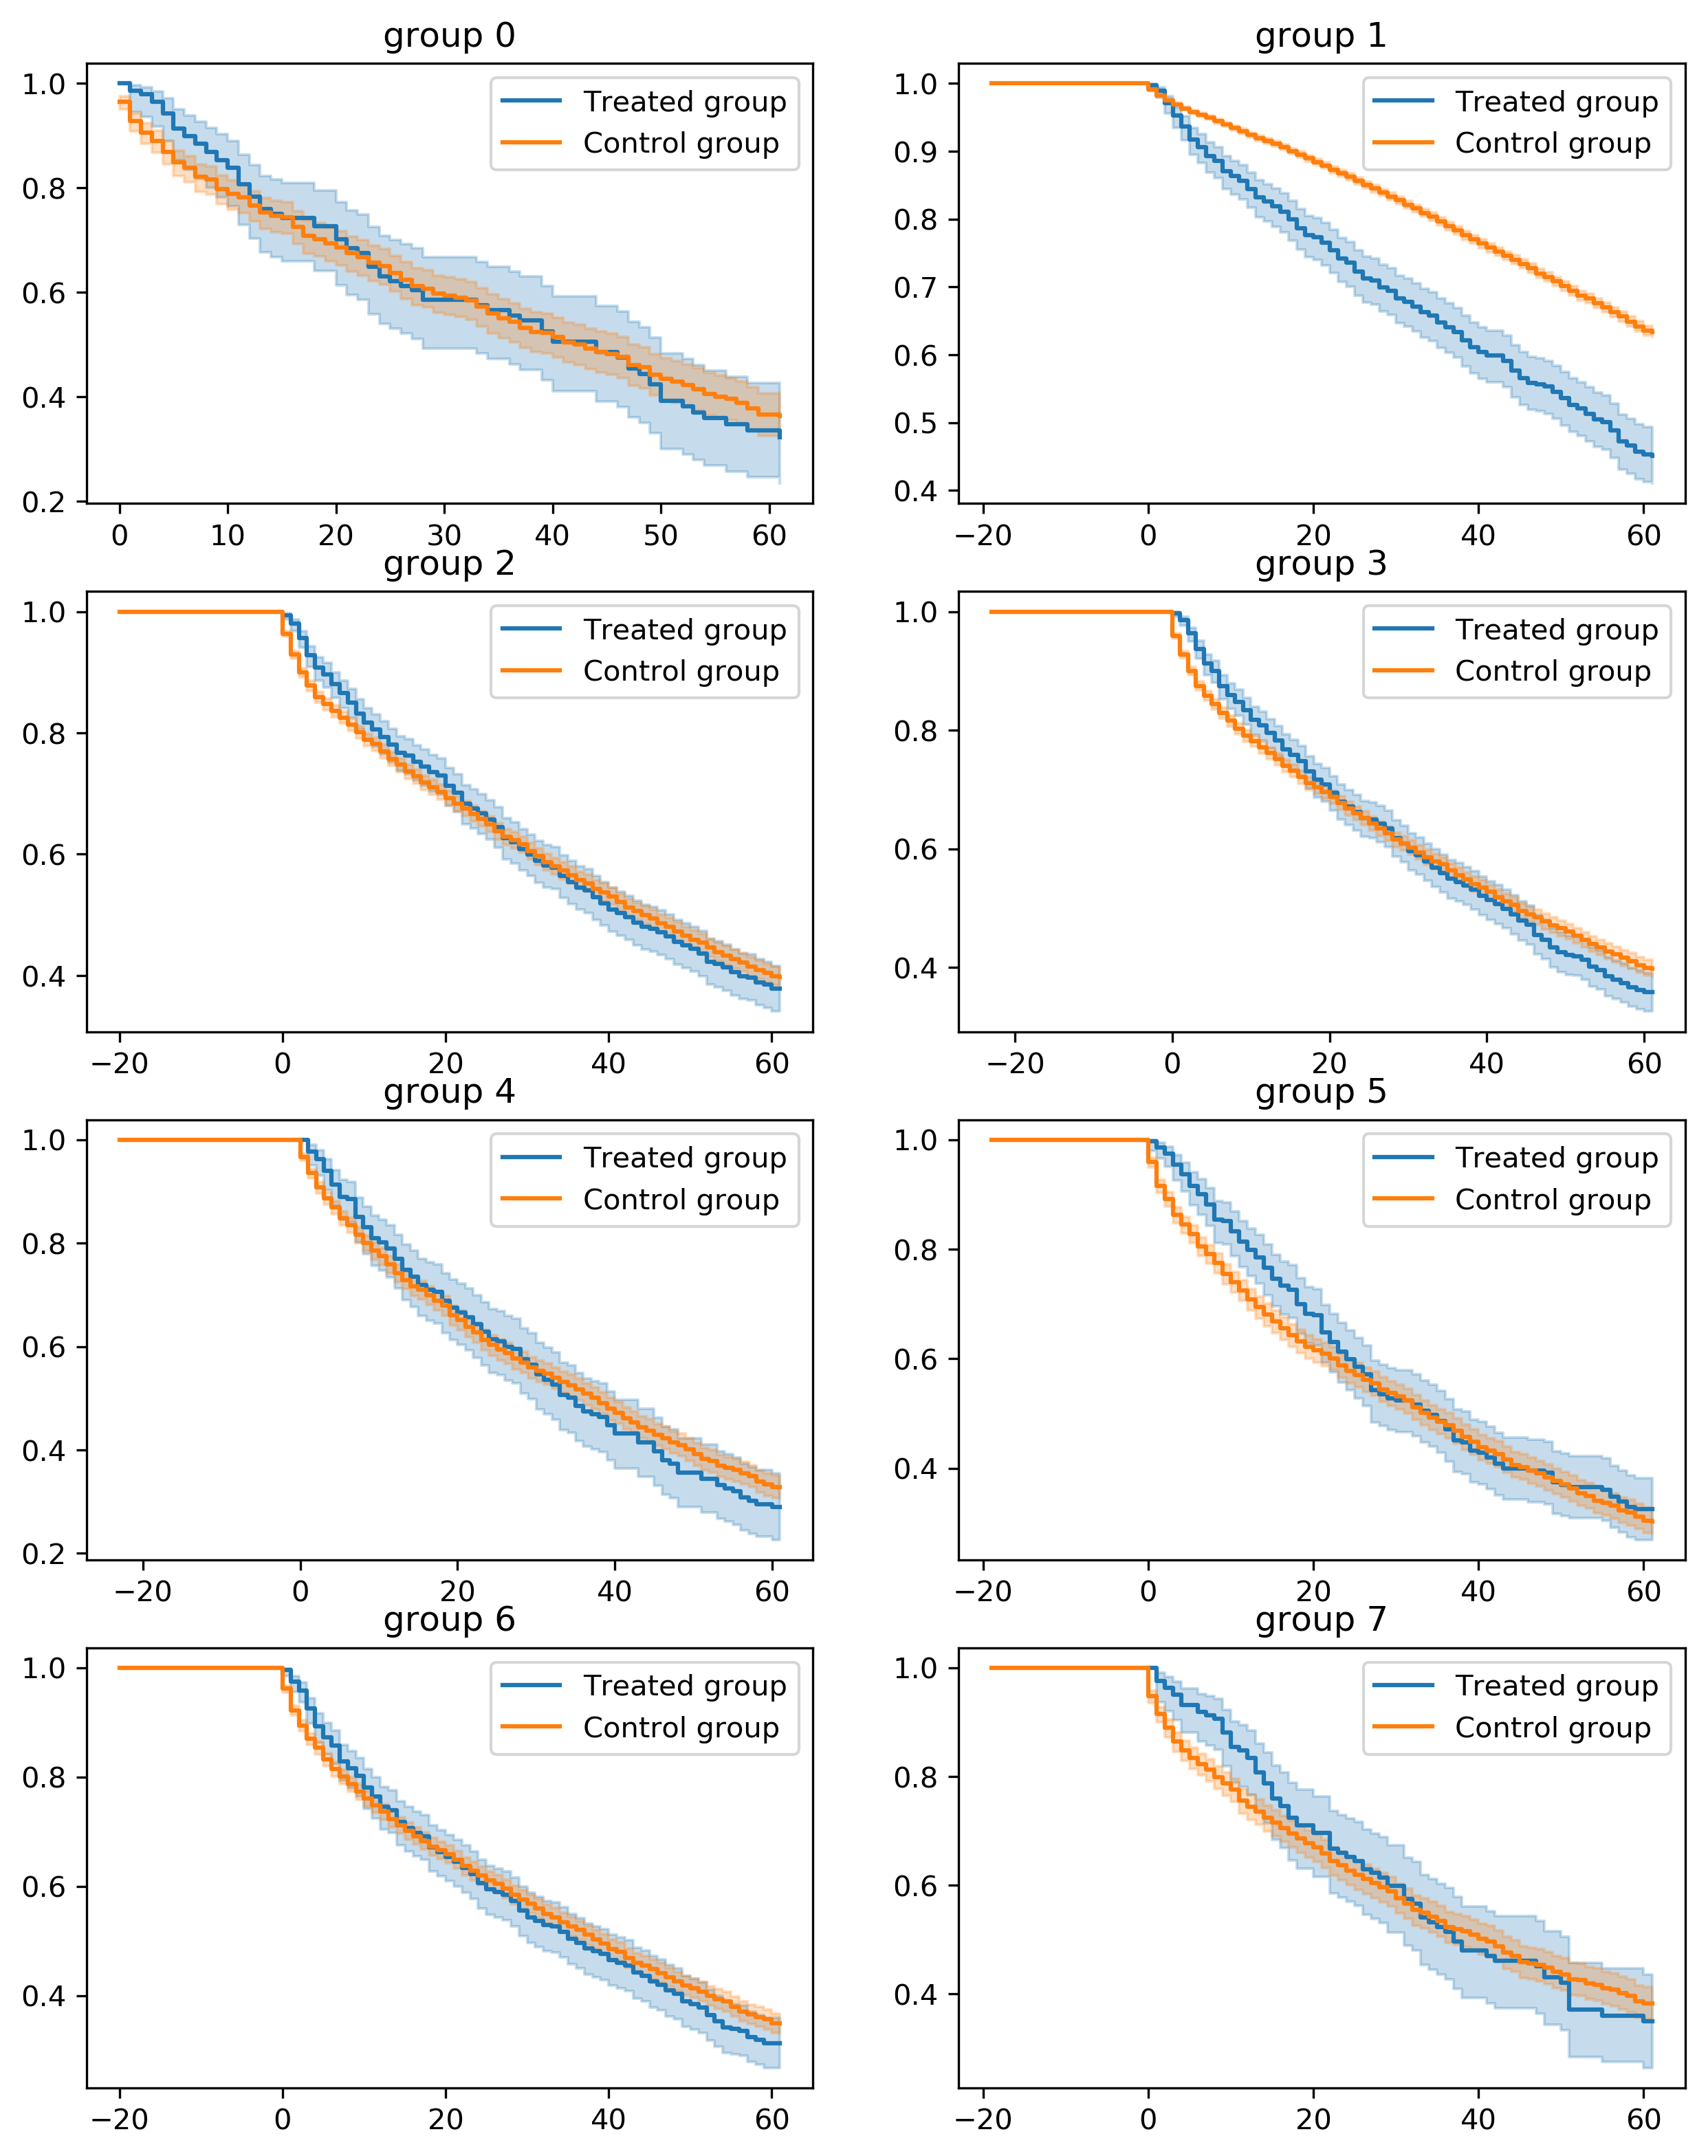

In [116]:
fig = plot(demo, 'digoxin', 'tfidf_label', 4, 2,groups=None, figsize=(10, 13))
plt.show()